In [1]:
from gensim.models import FastText
from konlpy.tag import Kkma
from konlpy.utils import pprint
import codecs
import logging

C:\Users\wmp\Anaconda3\envs\tf\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### nsmc 테스트

In [24]:
train_path = r'c:\Users\wmp\nsmc\ratings_train.txt'
test_path = r'c:\Users\wmp\nsmc\ratings_test.txt'

In [26]:
def read_data(filename):
    with codecs.open(filename, 'r', 'utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

In [27]:
train_data = read_data(train_path)

In [29]:
test_data = read_data(test_path)

In [30]:
len(test_data)

50000

In [31]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

In [32]:
def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

In [33]:
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

In [34]:
pprint(train_docs[0])

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 '0')


In [35]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


In [37]:
tokens[0:12]

['아/Exclamation',
 '더빙/Noun',
 '../Punctuation',
 '진짜/Noun',
 '짜증/Noun',
 '나다/Verb',
 '목소리/Noun',
 '흠/Noun',
 '.../Punctuation',
 '포스터/Noun',
 '보고/Noun',
 '초딩/Noun']

In [38]:
train_docs[0]

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 '0')

In [39]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [40]:
print(len(text.tokens))

2194536


In [41]:
pprint(text.vocab().most_common(10))

[('./Punctuation', 68630),
 ('영화/Noun', 51365),
 ('하다/Verb', 50281),
 ('이/Josa', 39123),
 ('보다/Verb', 34764),
 ('의/Josa', 30480),
 ('../Punctuation', 29055),
 ('에/Josa', 27108),
 ('가/Josa', 26696),
 ('을/Josa', 23481)]


In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

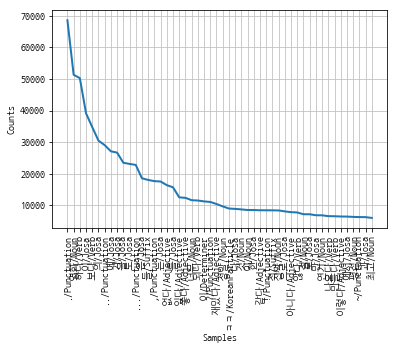

In [45]:
text.plot(50)

In [46]:
text.collocations()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  Searched in:
    - 'C:\\Users\\wmp/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Users\\wmp\\Anaconda3\\envs\\tf\\nltk_data'
    - 'C:\\Users\\wmp\\Anaconda3\\envs\\tf\\share\\nltk_data'
    - 'C:\\Users\\wmp\\Anaconda3\\envs\\tf\\lib\\nltk_data'
    - 'C:\\Users\\wmp\\AppData\\Roaming\\nltk_data'
**********************************************************************


In [47]:
selected_words = [f[0] for f in text.vocab().most_common(2000)]

In [48]:
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

In [49]:
# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_docs_small = train_docs[:10000]
train_xy = [(term_exists(d), c) for d, c in train_docs_small]
test_xy = [(term_exists(d), c) for d, c in train_docs_small]

In [54]:
# 초간단함
classifier = nltk.NaiveBayesClassifier.train(train_xy)
print(nltk.classify.accuracy(classifier, test_xy))
# => 0.80418
classifier.show_most_informative_features(10)
# => Most Informative Features

0.8445
Most Informative Features
         exists(수작/Noun) = True                1 : 0      =     38.0 : 1.0
         exists(최악/Noun) = True                0 : 1      =     30.1 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     24.5 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     22.1 : 1.0
         exists(낭비/Noun) = True                0 : 1      =     19.5 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     19.4 : 1.0
         exists(여운/Noun) = True                1 : 0      =     18.9 : 1.0
        exists(발연기/Noun) = True                0 : 1      =     16.9 : 1.0
          exists(굿/Noun) = True                1 : 0      =     16.9 : 1.0
        exists(최고다/Noun) = True                1 : 0      =     15.9 : 1.0


### gensim

In [55]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
# 여기서는 15만개 training documents 전부 사용함
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [ ]:
from gensim.models import doc2vec
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)
# Train document vectors!
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay
# To save
# doc_vectorizer.save('doc2vec.model')

In [3]:
from gensim import corpora, models, similarities

In [4]:
corpus = [[(0, 1.0), (1, 1.0), (2, 1.0)],
           [(2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (8, 1.0)],
           [(1, 1.0), (3, 1.0), (4, 1.0), (7, 1.0)],
           [(0, 1.0), (4, 2.0), (7, 1.0)],
           [(3, 1.0), (5, 1.0), (6, 1.0)],
           [(9, 1.0)],
           [(9, 1.0), (10, 1.0)],
           [(9, 1.0), (10, 1.0), (11, 1.0)],
           [(8, 1.0), (10, 1.0), (11, 1.0)]]

In [5]:
tfidf = models.TfidfModel(corpus)

2018-06-01 18:40:53,878 : INFO : collecting document frequencies
2018-06-01 18:40:53,879 : INFO : PROGRESS: processing document #0
2018-06-01 18:40:53,880 : INFO : calculating IDF weights for 9 documents and 11 features (28 matrix non-zeros)


In [6]:
vec = [(0, 1), (4, 1)]

In [7]:
print(tfidf[vec])

[(0, 0.8075244024440723), (4, 0.5898341626740045)]


In [8]:
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)

2018-06-01 18:42:04,510 : INFO : creating sparse index
2018-06-01 18:42:04,512 : INFO : creating sparse matrix from corpus
2018-06-01 18:42:04,513 : INFO : PROGRESS: at document #0
2018-06-01 18:42:04,519 : INFO : created <9x12 sparse matrix of type '<class 'numpy.float32'>'
	with 28 stored elements in Compressed Sparse Row format>


In [11]:
sims = index[tfidf[vec]]

In [12]:
print(list(enumerate(sims)))

[(0, 0.4662244), (1, 0.19139354), (2, 0.2460055), (3, 0.82094586), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0)]
